In [102]:
'''
This analysis is based in how the pandemy has evolved in Spain from peak days (arround 10k cases per day) until the end.

The data comes from: https://data.europa.eu/euodp/es/data/dataset/covid-19-coronavirus-data
englobing the data from the beggining of the year until the end of April.
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.signal import savgol_filter

#Import the dataset + visualize 
covid_df = pd.read_csv('Data.csv')
covid_df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,30/04/2020,30.0,4.0,2020.0,122.0,0.0,Afghanistan,AF,AFG,37172386.0,Asia
1,29/04/2020,29.0,4.0,2020.0,124.0,3.0,Afghanistan,AF,AFG,37172386.0,Asia
2,28/04/2020,28.0,4.0,2020.0,172.0,0.0,Afghanistan,AF,AFG,37172386.0,Asia
3,27/04/2020,27.0,4.0,2020.0,68.0,10.0,Afghanistan,AF,AFG,37172386.0,Asia
4,26/04/2020,26.0,4.0,2020.0,112.0,4.0,Afghanistan,AF,AFG,37172386.0,Asia


In [103]:
#Get some info from the dataset
print("Dataset shape - ", covid_df.shape,"\n")
covid_df.info()

Dataset shape -  (14035, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14035 entries, 0 to 14034
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  14035 non-null  object 
 1   day                      14006 non-null  float64
 2   month                    14006 non-null  float64
 3   year                     14006 non-null  float64
 4   cases                    14006 non-null  float64
 5   deaths                   14006 non-null  float64
 6   countriesAndTerritories  14006 non-null  object 
 7   geoId                    13959 non-null  object 
 8   countryterritoryCode     13875 non-null  object 
 9   popData2018              13899 non-null  float64
 10  continentExp             14006 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.2+ MB


In [104]:
#Find out which countries are, and find if Spain is there
countries = covid_df["countriesAndTerritories"]
dif_countries = countries.unique()
if "Spain" in dif_countries:
    print("Spain is here")

Spain is here


In [105]:
#Preprocess step
# Now we know our country is here, let's create a dataset from the global data
Spanish_df = covid_df[covid_df.countriesAndTerritories == "Spain"]
# Sort the data by date 
Spanish_df = Spanish_df.sort_values(by=["month","day"], ascending=True)
# Also filter the year
Spanish_df = Spanish_df[Spanish_df.year >= 2020]
# Filter negative values
Spanish_df = Spanish_df[Spanish_df.cases>=0]
Spanish_df = Spanish_df[Spanish_df.deaths>=0]

'''
There are a few data columns which are fairly useless in this case. As long as we'll only be dealing with data from Spain,
some columns used for classify the data into the global dataset are not necessary here:
- dateRep: Object tipe, does not allow to get a histogram + day/month/year are accessible.
- year: For the moment, everything is this same year, this column is not relevant.
- countriesAndTerritories, geold, countryterritoryCode and continentExp: Any of this data is necessary as long as we know 
we're working with spanish dataset.
'''

keys = Spanish_df.keys()
Spanish_df.pop(keys[0]) # reported date - object type
Spanish_df.pop(keys[3]) # year 
Spanish_df.pop(keys[6]) # countriesAndTerritories
Spanish_df.pop(keys[7]) # GeoId
Spanish_df.pop(keys[8]) # countryterritoryCode
Spanish_df.pop(keys[10]) # continentExp
Spanish_df

,day,month,cases,deaths,popData2018
12139,1.0,1.0,0.0,0.0,46723749.0
12138,2.0,1.0,0.0,0.0,46723749.0
12137,3.0,1.0,0.0,0.0,46723749.0
12136,4.0,1.0,0.0,0.0,46723749.0
12135,5.0,1.0,0.0,0.0,46723749.0
...,...,...,...,...,...
12024,25.0,4.0,2944.0,378.0,46723749.0
12023,26.0,4.0,1729.0,288.0,46723749.0
12022,27.0,4.0,1831.0,0.0,46723749.0
12021,28.0,4.0,1308.0,632.0,46723749.0


In [106]:
'''
There are new steps to filter. Visualizing deaths we can see there's many "0" cases , which might not be true as long as 
there've been many deaths each day although we're gonna filter by the "start" of the pandemy, we'll maintain the data from that
point.
'''
# Select the first day with case as "day 0" and erase the previous ones
i = 0
founded = False
for i in range(0, Spanish_df.shape[0]):
    if founded == False and Spanish_df.iloc[i]["cases"] != 0: # In case we did not find it yet and we find the first case
        founded = True
        row = i

# First detected case has been founded, let's maintain the rows we want
Spanish_df = Spanish_df[row:len(Spanish_df)- 5]

# Now we've worked a bit with the data reducing dimensionality, let's add the "day 0" to "today"
counting_days = np.arange(0,Spanish_df.shape[0])
Spanish_df["counting_days"] = counting_days

exp_Spanish_df = Spanish_df # Create a support dataset in case we need it.
Spanish_df

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,day,month,cases,deaths,popData2018,counting_days
12108,1.0,2.0,1.0,0.0,46723749.0,0
12107,2.0,2.0,0.0,0.0,46723749.0,1
12106,3.0,2.0,0.0,0.0,46723749.0,2
12105,4.0,2.0,0.0,0.0,46723749.0,3
12104,5.0,2.0,0.0,0.0,46723749.0,4
...,...,...,...,...,...,...
12029,20.0,4.0,2585.0,399.0,46723749.0,78
12028,21.0,4.0,3352.0,430.0,46723749.0,79
12027,22.0,4.0,2627.0,435.0,46723749.0,80
12026,23.0,4.0,3052.0,440.0,46723749.0,81


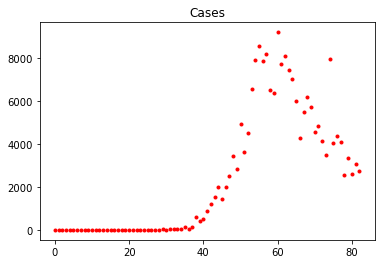

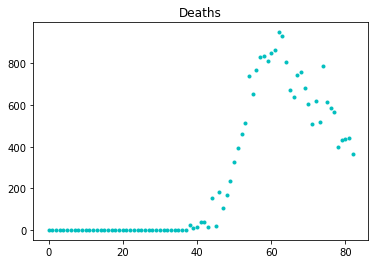

In [107]:
'''
Let's visualize the evolution, X axis will be "counting days" and Y axis will be cases and deaths.
'''
X_data = Spanish_df.counting_days
Y_cases = Spanish_df.cases
Y_deaths = Spanish_df.deaths

plt.plot(X_data, Y_cases, "r.")
plt.title("Cases")
plt.show()

plt.plot(X_data, Y_deaths, "c.")
plt.title("Deaths")
plt.show()

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


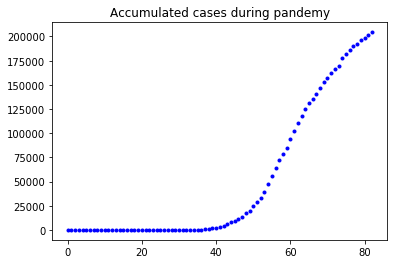

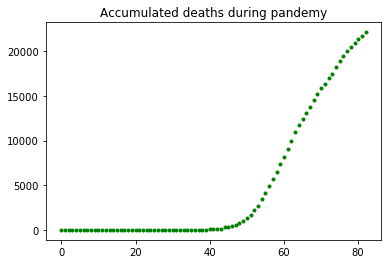

In [108]:
'''
Now, let's get accumulative values 
'''
Spanish_df["accumulated_cases"] = Spanish_df["cases"].cumsum()
Spanish_df["accumulated_deaths"] = Spanish_df["deaths"].cumsum()
total_cases = Spanish_df.accumulated_cases.sum()
total_deaths = Spanish_df.accumulated_deaths.sum()

Y_accumulated_cases = Spanish_df.accumulated_cases
Y_accumulated_deaths = Spanish_df.accumulated_deaths


plt.plot(X_data, Y_accumulated_cases, "b.")
plt.title("Accumulated cases during pandemy")
plt.show()

plt.plot(X_data, Y_accumulated_deaths, "g.")
plt.title("Accumulated deaths during pandemy")
plt.show()

c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\sergi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


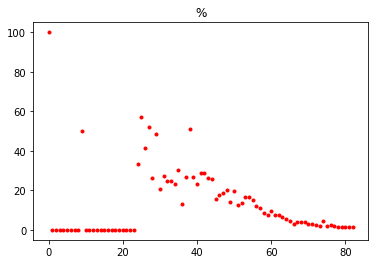

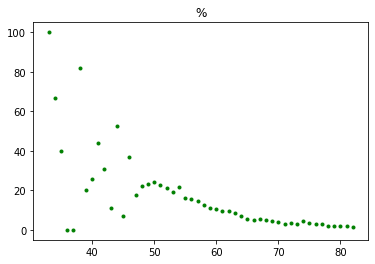

In [109]:
'''
This time, get the percentages evolution respect the total.
'''
Spanish_df["percentage_cases"] = (Spanish_df.cases/Spanish_df.accumulated_cases)*100
Spanish_df["percentage_deaths"] = (Spanish_df.deaths/Spanish_df.accumulated_deaths)*100

Y_perc_cases = Spanish_df.percentage_cases
Y_perc_deaths = Spanish_df.percentage_deaths

plt.plot(X_data, Y_perc_cases, "r.")
plt.title("%")
plt.show()
plt.plot(X_data, Y_perc_deaths, "g.")
plt.title("%")
plt.show()

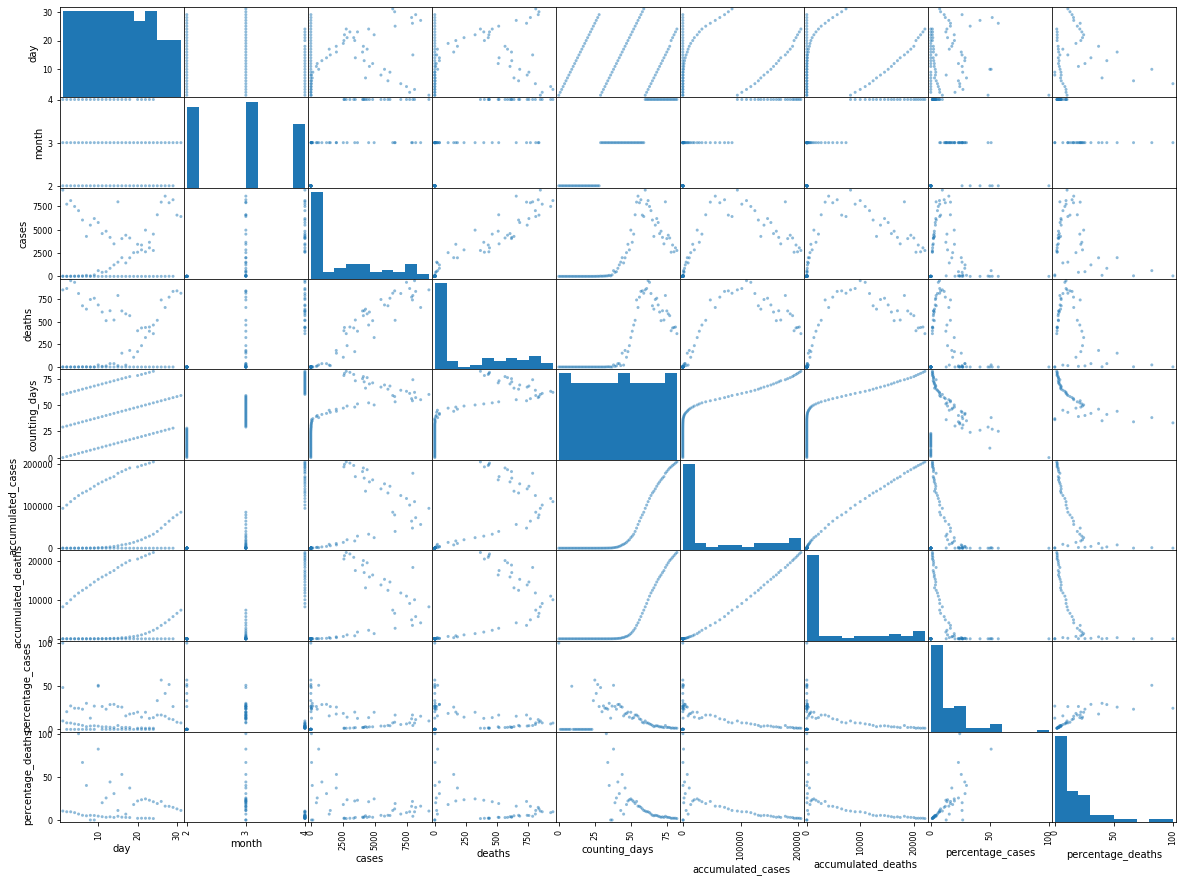

In [110]:
'''
At this moment we've seen graphically how the pandemy behaved in this country. Let's try to find out some kind of relation 
between the initial data (day - month - cases - deaths) using scatter matrix.
'''
corr_matrix = Spanish_df.corr()

'''
We're not interested in  all values as long as many features come from the initial ones, but let's have a look into the whole
image in order to visualize if there's any special relation to parametrize.
'''
from pandas.plotting import scatter_matrix
attributes = ["day","month","cases","deaths","counting_days", "accumulated_cases", "accumulated_deaths",
             "percentage_cases","percentage_deaths"] 
matrix = scatter_matrix(Spanish_df[attributes], figsize = (20,15))

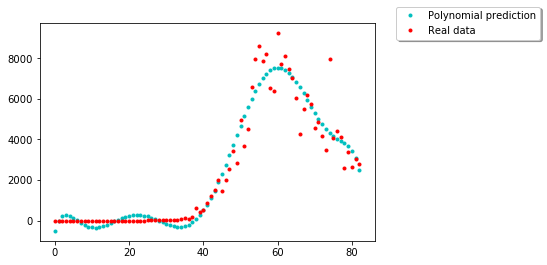

In [111]:
'''
We can extract non related parameters from this grid in order to maintain the related ones:
- Day and month are erasable as long as there's no clear relation.
- Cases have linear relation with deaths, deaths%, parabolic relation with all accumulated features.
- deaths have overall the same relations.
- Counting days perform the graphics we've created before.
- Accumulated cases has a logaritmic shape.
'''

'''
What we want to do is to "try" to predict future amount of cases (that means modelling cases with counting days, and by 
extension, give also percentages). Moreover, deaths are also related with counting days and all percentages.

Firstly, we're looking at cases (Y) with counting days (X). Looks like somehow exponential (firstly growing up then decaying)
try out polynomial as long as exponential does not have generic regression object. In case polynomial does not fit well enough,
we'll move to exponential.
'''

X_data = np.array(Spanish_df.counting_days)
X_data = X_data.reshape(-1,1) # Reshape data to fit 



polynomial_features = PolynomialFeatures(degree=8)
x_poly = polynomial_features.fit_transform(X_data) # Create the object + fit it


model = LinearRegression() # Even it's polinomial, it's inside the lineality
model.fit(x_poly, Y_cases)

y_poly_pred = model.predict(x_poly)

# Now model has been predicted, let's visualize obtained data with the predicted model
plt.plot(X_data, y_poly_pred, "c.", label = "Polynomial prediction")
plt.plot(X_data, Y_cases, "r.", label = "Real data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

plt.show()

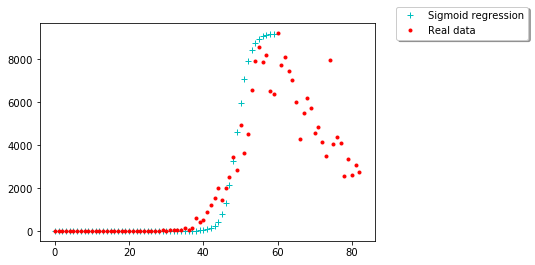

In [112]:
'''
Testing out sigmoid to the exponential grow in order to see the performance.
'''
coef = max(Spanish_df.cases)
# First piece function
def sigmoid(x,Beta_1,Beta_2):
    y=1/(1+np.exp(-Beta_1*(x-Beta_2)))
    return y

#Try out some values
beta_1=0.6
beta_2=49

X_data2 = X_data[0:60]
Y_sigmoid_pred = sigmoid(X_data2, beta_1, beta_2)

# Plotting scenario
plt.plot(X_data2, Y_sigmoid_pred*coef,"c+", label = "Sigmoid regression")
plt.plot(X_data, Y_cases, "r.", label = "Real data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.show()

In [113]:
'''
Evaluate the error b
'''
Y_cases2 = Y_cases[0:60]
sigmoid_mse = mean_squared_error(Y_cases2, Y_sigmoid_pred)
lin_rmse = np.sqrt(sigmoid_mse)

polynomial_mse = mean_squared_error(y_poly_pred[0:60], Y_cases2)
polynomial_rmse = np.sqrt(polynomial_mse)

print("Polynomial error")
print("MSE error:", polynomial_mse)
print("RMSE error:", polynomial_rmse)


print("\nSigmoid errors")
print("MSE error:", sigmoid_mse)
print("RMSE error:",lin_rmse)

Polynomial error
MSE error: 328012.93026666186
RMSE error: 572.7241310322639

Sigmoid errors
MSE error: 8208122.524068717
RMSE error: 2864.9821158375


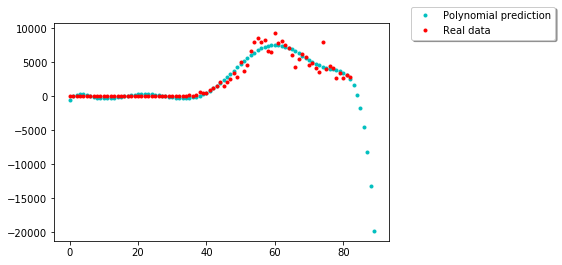

In [114]:
'''
Although Polynomial performs way better than sigmoid, using too bigger degrees becomes a big problem.
Would be a good option to use exponential.
'''
X_data2 = np.arange(0,90)
#X_data2 = np.array([20,40,60])
X_data3 = X_data2.reshape(-1,1)

x_poly2 = polynomial_features.fit_transform(X_data3) # Create the object + fit it

y_poly_pred2 = model.predict(x_poly2)

plt.plot(X_data2, y_poly_pred2, "c.",label = "Polynomial prediction")
plt.plot(X_data, Y_cases, "r.", label = "Real data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.show()

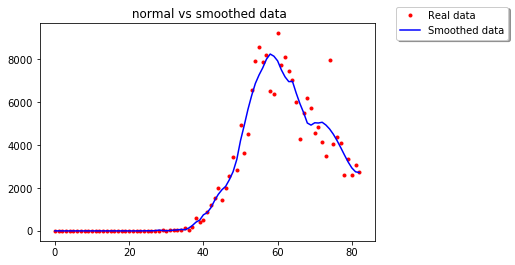

In [115]:
'''
This is an example on how using polynomial regression does not help that much, only performs well with the data which is 
already stored, the "future" data does not perform in a logical way. 
Let's try out piecewise function to fit the data and smooth the curves using savitzky-golay.
'''

#First step: Take data and smooth Y values.

Y_data = exp_Spanish_df.cases
X_data = exp_Spanish_df.counting_days

Y_data_s = savgol_filter(Y_data,21,4)

plt.plot(X_data, Y_data, "r.", label = "Real data")
plt.plot(X_data, Y_data_s,"b-", label = "Smoothed data")
plt.title(" normal vs smoothed data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

plt.show()

[]

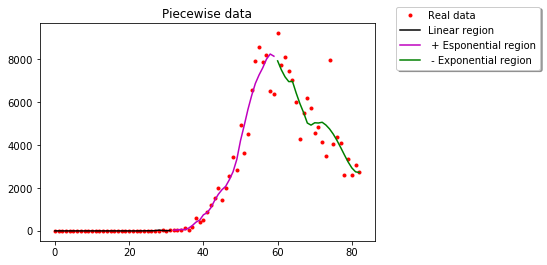

In [116]:
'''
Let's split the data in three parts, (both exponentially but + and -) and will be splitted by the highest value arround 
the day 60 and 40 (visual detection).
'''

max_value = max(Spanish_df.cases) # Selecting the highest value
exp_index = 0
lin_index = 0
# Find the crutial point
for i in range(0, len(Spanish_df.cases)):
    if (Spanish_df.cases.iloc[i] == max_value and exp_index == 0):
        exp_index = i
    if(Spanish_df.cases.iloc[i] >= 35 and lin_index == 0):
        lin_index = i


# Generate the splitted values
func_1_x = exp_Spanish_df.counting_days[:lin_index]
func_2_x = exp_Spanish_df.counting_days[lin_index:exp_index]
func_3_x = exp_Spanish_df.counting_days[exp_index:]


func_1_y = Y_data_s[:lin_index]
func_2_y = Y_data_s[lin_index:exp_index]
func_3_y = Y_data_s[exp_index:]

# Visualize the data 
plt.plot(X_data, Y_data, "r.", label = "Real data")
plt.plot(func_1_x, func_1_y, "k-", label = "Linear region")
plt.plot(func_2_x, func_2_y, "m-", label = " + Esponential region")
plt.plot(func_3_x, func_3_y, "g-", label = " - Exponential region")
plt.title("Piecewise data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

plt.plot()

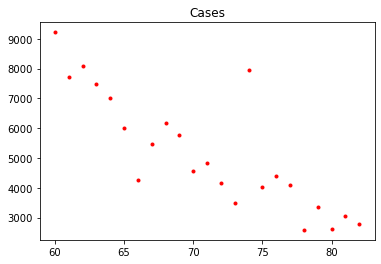

In [117]:
# From this point, we want to modelize the green curve in order to "predict" the future's cases.

X_data = Spanish_df.counting_days[exp_index:]
Y_cases = Spanish_df.cases[exp_index:]
Y_deaths = Spanish_df.deaths[exp_index:]

plt.plot(X_data, Y_cases, "r.")
plt.title("Cases")
plt.show()

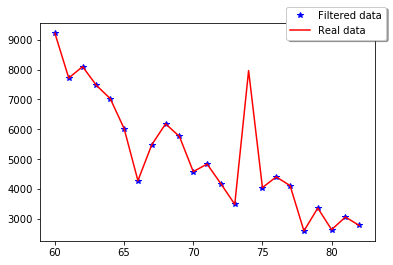

In [118]:
#Smooth the data & delete outlier values. In this case we can see an outlier arround 75 day which disturbs the trending.
#Let's use 7000 as threshold based in the exponential trend.
threshold = 7000
Y_cases = np.array(Y_cases)
X_data = np.array(X_data)
Y_cases_filtered = []
X_data_filtered = []

for day in range(0,len(Y_cases)):
    if day < int(len(Y_cases)/2): # Previous erasing values
        Y_cases_filtered.append(Y_cases[day])
        X_data_filtered.append(X_data[day])
    else:
        if Y_cases[day] < threshold: # In case value is below threshold keep storing it
            Y_cases_filtered.append(Y_cases[day])
            X_data_filtered.append(X_data[day]) 

# Let's visualize the new plot
plt.plot(X_data_filtered, Y_cases_filtered, "b*", label = "Filtered data")
plt.plot(X_data, Y_cases, "r-", label = "Real data")
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

plt.show()

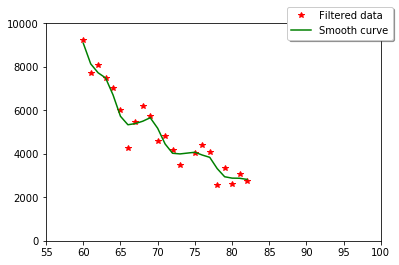

In [119]:
# Time to smooth the data through savitzky-golay
Y_cases_smooth = savgol_filter(Y_cases_filtered,7,3)
plt.plot(X_data_filtered, Y_cases_filtered, "r*", label = "Filtered data")
plt.plot(X_data_filtered, Y_cases_smooth, "g-", label = "Smooth curve")
plt.xlim(55, 100)
plt.ylim(0,10000)

plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.show()

[]

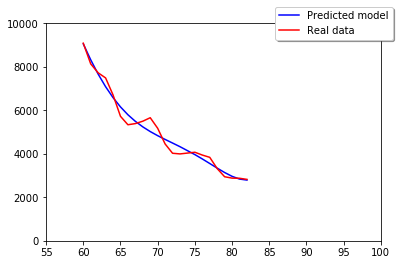

In [120]:
'''
Now we have this data, let's try out again polynomial regression to visualize if performs better or at least looks like 
pandemic decrease should be.
'''

X_data_reshaped = np.array(X_data_filtered).reshape(-1,1)

polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(X_data_reshaped)

model = LinearRegression() # Even it's polinomial, it's inside the lineality
model.fit(x_poly, Y_cases_smooth)

y_poly_pred = model.predict(x_poly)

plt.plot(X_data_reshaped, y_poly_pred,"b-", label = "Predicted model")
plt.plot(X_data_reshaped, Y_cases_smooth,"r-", label = "Real data")
plt.xlim(55, 100)
plt.ylim(0,10000)
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.plot()

[]

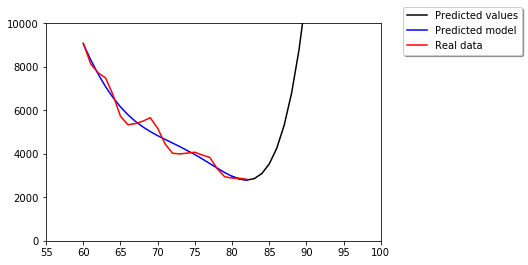

In [121]:
'''
Now let's predict the "future values" using the last regression.
'''
predict_value = np.arange(80,101)
predict_value = predict_value.reshape(-1,1)
X_predict_value = polynomial_features.fit_transform(predict_value)

Y_predict_value = model.predict(X_predict_value)

plt.plot(predict_value, Y_predict_value, "k-", label = "Predicted values")
plt.plot(X_data_reshaped, y_poly_pred,"b-", label = "Predicted model")
plt.plot(X_data_reshaped, Y_cases_smooth,"r-", label = "Real data")
plt.xlim(55, 100)
plt.ylim(0,10000)
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.plot()

In [122]:
'''
Polynomial in this case neither works as the equation exponentially grows. Let's try out exponential finally. 
Let's interpolate data to generate enough points to fit. In order to achieve it, let's fill the data with the predicted values
from the polynomial regression, as long as fits kindly well at least in that space.
'''
X_new_data = np.linspace(60,80,1000)
X_new_data_reshaped = X_new_data.reshape(-1,1)

x_poly_new_data = polynomial_features.fit_transform(X_new_data_reshaped)

Y_predict_new_data = model.predict(x_poly_new_data)

'''
We'll use the simplest exponential A*exponential(-b*X) doing the following considerations:
- Exponential value to 0 is 1. Assuming our 0 is 9000, we need to scale using the [A] parameter.
- Coefficient [-b] in order to decrease the value exponentially.
- There's no [C] coefficient as long as the pandemy should tend to 0.

Moreover, as long as A coefficient is the max value of the dataset, we just need to fit b parameter. For doing it, instead 
using pre-builded functions, let's just iterate and measure the error compared with the current data and store the best
coefficient value.
'''

def exponential(x, a, b):
    return a*np.exp(-b*x)

a = max_value # Exponential values for 0 is 1, as long as the "first data" is the max value, assume this is the coeficient
error = 9999999999
b = 0

X_new_data = np.linspace(0,20,1000)
# Small algorithm to decrement the error with the exponential value
testing = np.linspace(0, 0.1, 5000)
for value in testing:
    y = exponential(X_new_data2,a,value)
    # Calculate the error
    error_actual = mean_squared_error(y, Y_predict_new_data)
    if error_actual < error:
        b = value
        error = error_actual
print("least error exponential:", b)

least error exponential: 0.062252450490098026


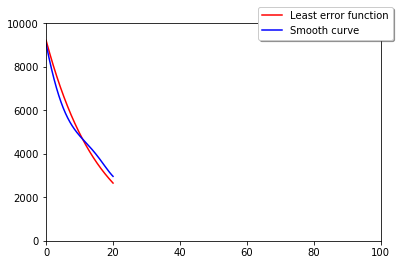

In [123]:
'''
Let's see how it performs!
'''
y = exponential(X_new_data2,a,b)

plt.plot(X_new_data2, y, "r-", label = "Least error function")
plt.plot(X_new_data2, Y_predict_new_data, "b-", label = "Smooth curve")
plt.xlim(0, 100)
plt.ylim(0,10000)
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)
plt.show()

In [124]:
'''
At this moment, the curve is likely "performed". Let's "predict" the curve the followingdays, don't forget the
"0" day is April the first:
- 30: first of may.
- 60: first of june.
- 90: first of july.

Do not forget this values are based from 0 (pseudo-centered)!!
'''
zero_day = Spanish_df[Spanish_df.counting_days == exp_index]
zero_day

,day,month,cases,deaths,popData2018,counting_days,accumulated_cases,accumulated_deaths,percentage_cases,percentage_deaths
12048,1.0,4.0,9222.0,849.0,46723749.0,60,94417.0,8189.0,9.767309,10.367566


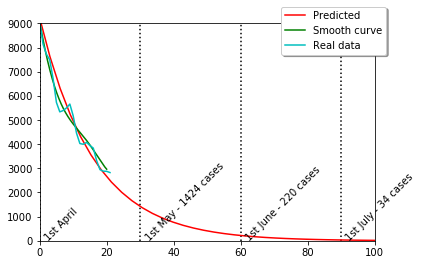

<Figure size 2880x1440 with 0 Axes>

In [125]:
# Let's see the predictions for the future months
X_testing = np.linspace(0,150)
y_pred = exponential(X_testing,a,b)

plt.plot(X_testing, y_pred,"r-", label = "Predicted")
plt.plot(X_new_data2, Y_predict_new_data, "g-", label = "Smooth curve")
plt.plot(np.arange(0,22), Y_cases_smooth,"c-", label = "Real data")

plt.xlim(0, 100)
plt.ylim(0,9000)
plt.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)


plt.vlines(0.1,0,9000,colors='k', linestyles='dotted')
plt.text(1,0, "1st April", rotation = 45)

plt.vlines(30,0,9000,colors='k', linestyles='dotted')
plt.text(31,0, "1st May - %i cases"%(exponential(30,a,b)), rotation = 45)

plt.vlines(60,0,9000,colors='k', linestyles='dotted')
plt.text(61,0, "1st June - %i cases"%(exponential(60,a,b)), rotation = 45)

plt.vlines(90,0,9000,colors='k', linestyles='dotted')
plt.text(91,0, "1st July - %i cases"%(exponential(90,a,b)), rotation = 45)

plt.figure(figsize=(40,20))
plt.show()


In [126]:
# Let's see which day is the first one without cases
for i in range(0,200):
    cases = exponential(i,a,b)
    if cases < 1:
        print("First day with less than 1 case:", i)
        break

First day with less than 1 case: 147


In [127]:
'''
This is 147 days from 1st of April - which is 5 months (aprox) , on early September.
'''

'\nThis is 147 days from 1st of April - which is 5 months (aprox) , on early September.\n'